In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score
sns.set()

In [2]:
train_data = pd.read_csv('../../Data/serendipity-sac2018/training.csv')

In [3]:
train_data['timestamp'] = train_data['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000))
train_data['year'] = train_data['timestamp'].apply(lambda x: x.year)
train_data['month'] = train_data['timestamp'].apply(lambda x: x.month)


In [4]:
train_data = train_data[train_data['year'] > 2015]

In [83]:
movies = pd.read_csv('../../Data/serendipity-sac2018/movies.csv',error_bad_lines=False)

Skipping line 19833: expected 8 fields, saw 10
Skipping line 34143: expected 8 fields, saw 9
Skipping line 36015: expected 8 fields, saw 10
Skipping line 37260: expected 8 fields, saw 12
Skipping line 44379: expected 8 fields, saw 10
Skipping line 47551: expected 8 fields, saw 10



In [89]:
## Remove movies with no genre 
movies = movies[movies['genres'].isna() == False]
movies.reset_index(drop=True, inplace=True)

## Convert string to array of genres
movies['genres'] = movies['genres'].apply(lambda x: x.split(','))

In [90]:
vect = CountVectorizer()
X = vect.fit_transform(movies.genres.str.join(' '))
movies = movies.join(pd.DataFrame(X.toarray(), columns=vect.get_feature_names()))

In [101]:
movies.head()

,movieId,title,releaseDate,directedBy,starring,imdbId,tmdbId,genres,action,adventure,...,horror,imax,musical,mystery,noir,romance,sci,thriller,war,western
0,1,Toy Story (1995),1995-11-19,John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney,...",114709,862.0,"[Adventure, Animation, Children, Comedy, Fantasy]",0,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),1995-12-15,Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams,...",113497,8844.0,"[Adventure, Children, Fantasy]",0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),1995-01-01,Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sop...",113228,15602.0,"[Comedy, Romance]",0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),1996-01-15,Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Housto...",114885,31357.0,"[Comedy, Drama, Romance]",0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),1995-12-08,Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimb...",113041,11862.0,[Comedy],0,0,...,0,0,0,0,0,0,0,0,0,0


In [109]:
## Run KModes clustering on [2,10] clusters to identify optim

silhouette_score
sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    print("K = " + str(k))
    km = KModes(n_clusters=k, init='Huang', n_init=3, verbose=0)
    clusters = km.fit_predict(data)
    sil.append(silhouette_score(data, clusters, metric = 'euclidean'))

K = 2
K = 3
K = 4
K = 5
K = 6
K = 7
K = 8
K = 9
K = 10


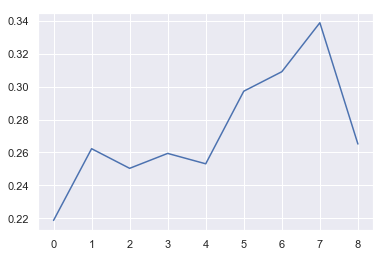

In [110]:
plt.plot(sil)

**Picking 5 clusters**

In [111]:
km = KModes(n_clusters=5, init='Huang', n_init=3, verbose=0)
clusters = km.fit_predict(data)
movies['clusters'] = clusters

In [116]:
train_data = train_data.merge(movies[['movieId','clusters']], on = 'movieId')

In [121]:
## Avg ratings for each cluster per user

avg_rating = train_data[['userId', 'clusters','rating']].groupby(['userId', 'clusters']).agg('mean')
avg_rating

rating
userId clusters          
100032 0         3.642857
       1         3.910714
       2         4.066667
       3         3.904762
100036 0         3.888889
       1         4.261364
       2         3.666667
       3         3.857143
       4         4.500000
100041 0         1.416667
       1         1.657895
       2         2.413043
       3         3.450000
100053 0         3.290850
       1         3.611979
       2         3.166667
       3         3.320513
       4         4.250000
100057 0         3.000000
       1         3.500000
100058 0         3.142857
       1         4.250000
       2         3.500000
100060 1         4.750000
       2         4.000000
100062 0         3.562500
       1         3.125000
       2         3.416667
       3         3.250000
100067 0         3.900000
...                   ...
206967 1         2.400000
       2         2.735294
       3         2.000000
206968 0         3.416667
       1         3.727273
       2         3.352941
       3         4.500000
       4         3.388889
206975 0         4.300000
       1         3.750000
       2         3.000000
       3         3.500000
206981 0         3.160714
       1         3.178571
       2         3.088785
       3         3.052632
       4         4.500000
206982 0         4.500000
       1         3.500000
       2         4.300000
       3         4.250000
206984 0         4.250000
       1         4.000000
       2         3.500000
       4         5.000000
206985 0         4.500000
       1         4.083333
       2         4.250000
       3         4.000000
       4         3.500000

[136057 rows x 1 columns]

In [154]:
UM_matrix = train_data.pivot(index='userId', columns='movieId', values='rating')

In [172]:
# UM_matrix

In [171]:
for userId, row in UM_matrix.iterrows():    
    for movieId in UM_matrix.columns:
        if math.isnan(UM_matrix.loc[userId, movieId]):
            cluster = movies.loc[movies['movieId'] == movieId,'clusters'].values[0]
            try:
                UM_matrix.loc[userId, movieId] = avg_rating.loc[userId, cluster].values[0]
            except TypeError:
                ## If a user has not rated a movie in that cluster, assign user's average rating across all clusters.
                UM_matrix.loc[userId, movieId] =avg_rating.loc[userId, :].agg('mean').values[0]
            except:
                print "Unknown error for " + str(userId) + ";" + str(movieId)
            
    

Unknown error for 100057;26622
Unknown error for 100057;59895


KeyboardInterrupt: 